### Investigate final_score_unweighted has 16,582 zero values


In [58]:
%run '../lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [59]:
dfFlt = load_df('dfFlt')
types = get_var_types()

#### Create zero value dataframe

In [60]:
zeroDf = dfFlt.filter(F.col('final_score_unweighted') == 0)

#### Count zero values

In [61]:
zeroDf.count()

16582

- 16,582 zero values

In [41]:
display_single_val(zeroDf)

,0
assignment_late_submission,False
is_manual_scoring_required,False
learner_attempt_status,fully scored
final_score_unweighted,0
is_deleted,False


- No additional values

###### Categorical / Nominal Correlations Heatmap

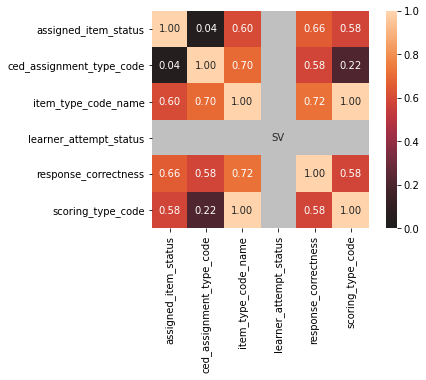

In [42]:
corr, ax = associations( zeroDf.select(*types['nominalVars']).toPandas(), nan_replace_value='null' )

- No new correlations

###### Categorical / Interval Variables

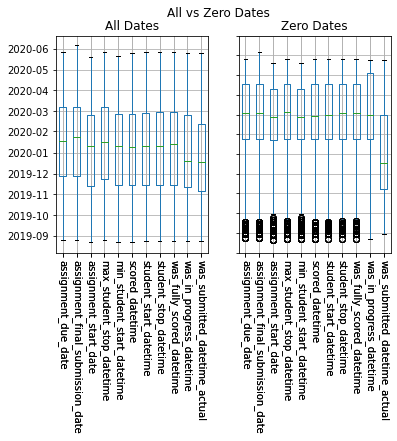

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

date_boxplot(get_random_sample(dfFlt), "All Dates", ax1)

date_boxplot(zeroDf, "Zero Dates", ax2)

plt.suptitle('All vs Zero Dates')

plt.show()

- Median shifted one and half months from 1/15/2020 to 3/2020
- All distributions right skewed
- Majority of dates in the last half of school year
  - Possible correlation to pandemic starting in last part of school year

###### Binary Correlations Heatmap

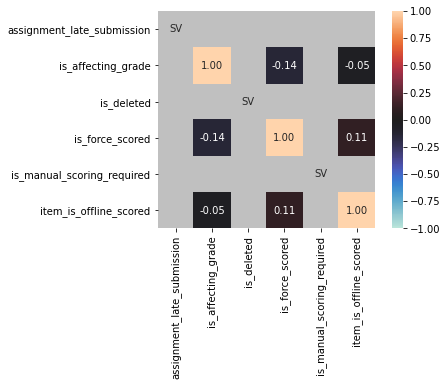

In [44]:
corr, ax = associations( zeroDf.select(*types['binaryVars']).toPandas(), nan_replace_value='null' )

- No correlation
- Unary values in assignment_late_submission, is_manual_scoring_required and is_deleted
  - Remove unary values

###### Check for Correlations of Zero to Categorical Variables

In [45]:
dfZeroCat = add_zero_score_var(dfFlt)

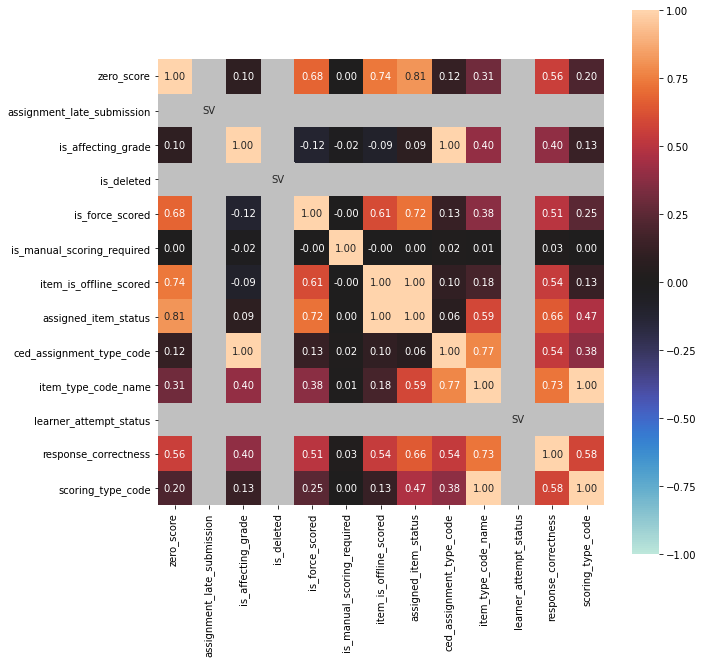

In [47]:
cols = ['zero_score'] + types['binaryVars'] + types['nominalVars']
pdDf = dfZeroCat.select(*cols).toPandas()
corr, ax = associations(pdDf , nan_replace_value='null', figsize=[10,10])

- High correlation between zero_score and assigned_item_status
- Unexpected low correlation between zero_score and response_correctness

###### Display Crosstab of zero_score vs assigned_item_status

In [49]:
crosstab_percent( pd.crosstab(pdDf.zero_score, pdDf.assigned_item_status) )

assigned_item_status,assigned,offline_scored,responded,scored
zero_score,,,,
No,1.0,2.0,0.0,97.0
Yes,15.0,68.0,0.0,17.0


- zero_score = No  when assigned_item_status = scored
- zero_score = Yes when assigned_item_status = offline_scored
  - Is this a error?
  - It doesn't make sense offline_scored correlates to a score of zero

###### Check for correlation of null assessment_item_response_id and zero score
- There are 15,710 nulls which is close to the 16,582 zeros

In [51]:
# Add binary categorical null_resp
pdDf = dfZeroCat.withColumn(
                "null_resp",
                  F.when( F.col('assessment_item_response_id').isNull(), 'Yes').otherwise("No")
                ).toPandas()

crosstab_percent( pd.crosstab(pdDf.zero_score, pdDf.null_resp) )

null_resp,No,Yes
zero_score,,
No,97.0,3.0
Yes,17.0,83.0


- Highly correlated
  - majority are zero because there is no response to question
- Also a high correlation of assigned_item_status = offline_scored
- These are questions that haven't been answered

###### Display Crosstab of zero_score vs response_correctness

In [52]:
crosstab_percent( pd.crosstab(pdDf.null_resp, pdDf.response_correctness) )

response_correctness,[unassigned],correct,incorrect,partially_correct
null_resp,,,,
No,2.0,67.0,28.0,2.0
Yes,0.0,0.0,100.0,0.0


- 100% incorreect when no response

###### Compare Num Sections by Organization

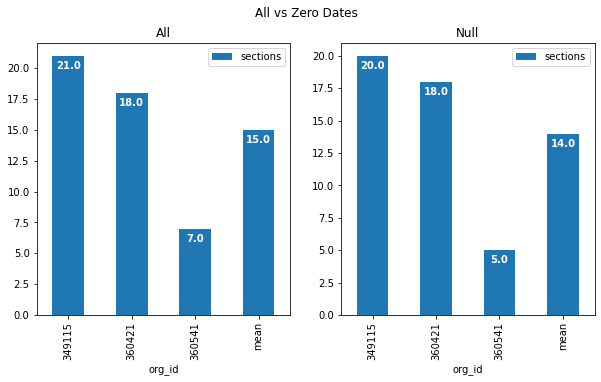

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

num_sections_by_org_bar_chart(dfFlt, ax=ax1, title='All')

num_sections_by_org_bar_chart(zeroDf, ax=ax2, title='Zero')

plt.suptitle('All vs Zero Scores')

plt.show()


- Equally across all organzations
- Equally accross all sections
  - Two sections in org 360541 had no zero scores

##### Mean Section Assessments by Organization

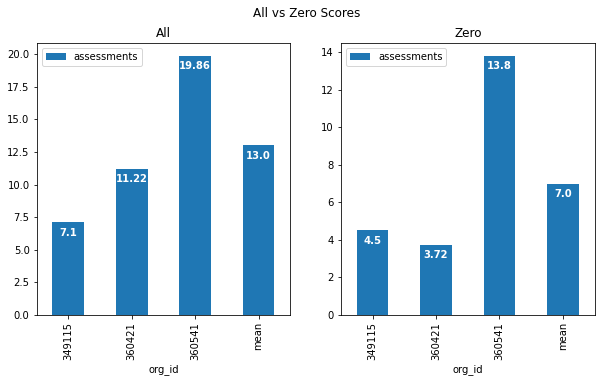

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

mean_sec_assess_by_org_bar_chart(dfFlt, ax=ax1, title='All')

mean_sec_assess_by_org_bar_chart(zeroDf, ax=ax2, title='Zero')

plt.suptitle('All vs Zero Scores')

plt.show()

- Impacted all
- Impacted 360421 more than others


##### Mean Learners Assessments by Organization

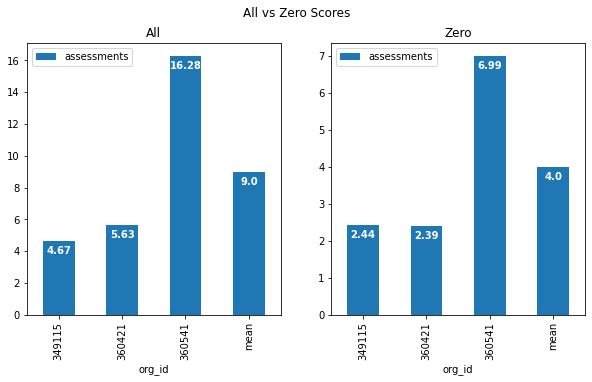

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

mean_assess_by_org_bar_chart(dfFlt, ax=ax1, title='All')

mean_assess_by_org_bar_chart(zeroDf, ax=ax2, title='Zero')

plt.suptitle('All vs Zero Scores')

plt.show()

- Impacted all
- Impacted 360421 more than others

##### Is the zero scores, questions of a full assessment

Notes:
- assessment_id 1 to 1 assessment_instance_id
- assessment_instance_attempt_id 1 to 1 learner_assignment_attempt_id
- learner_assigned_item_attempt_id 1 to 1 assessment_item_response_id

In [127]:
# Count items and responses for each assessment attempt
dfAtmpt = dfFlt.groupBy('learner_assignment_attempt_id').agg(
    F.count(F.col('learner_assigned_item_attempt_id')).alias('item'),
    F.count(F.col('assessment_item_response_id')).alias('response'),
    F.count(F.when(F.col('assessment_item_response_id').isNull(), 1)).alias('null_response'),
)

###### Number of attempts

In [128]:
dfAtmpt.count()

8855

- 8,855 attempts (vs initial count of 8,855)

###### Number of learner_assigned_item_attempt_id

In [129]:
dfAtmpt.agg(F.sum(F.col('item'))).show()

+---------+
|sum(item)|
+---------+
|    80548|
+---------+



- 80,548 (vs count of 79,689)

###### Number of assessment_item_response_id

In [130]:
dfAtmpt.agg(F.sum(F.col('response'))).show()

+-------------+
|sum(response)|
+-------------+
|        64838|
+-------------+



- 64,838 (vs count of 64,368)

###### Number of null assessment_item_response_id

In [132]:
dfAtmpt.agg(F.sum(F.col('null_response'))).show()

+------------------+
|sum(null_response)|
+------------------+
|             15710|
+------------------+



- 15,710 (equals earlier count of 15,710)

###### Assessments with no questions answered

In [ ]:
dfAtmpt.filter( (F.col('item') > 0) & (F.col('response') == 0) ).count()

1,911 assessments with no questions answered

###### Assessments with 1 question not answered

In [133]:
dfAtmpt.filter( F.col('item') != F.col('response') ).count()

2198

2,198 assessments with 1 question not answered

##### Conclusion:
- The 16,582 zero values is due to
  - 1,911 assessments with no questions answered
  - 2,198 assessments with 1 question not answered
